In [74]:
import pickle

import sys
sys.path.append('..')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from data_loader.load_data import ImagesLoader

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier, \
                             ExtraTreesClassifier, \
                             StackingClassifier, \
                             VotingClassifier, \
                             BaggingClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, \
                            f1_score, \
                            classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

import scikitplot as skplt

from skopt import gp_minimize
from skopt.plots import plot_convergence

from simpsons_classifier.voter import Voter as vote
import simpsons_classifier.load_stacking_models as stack
from simpsons_classifier.simpsons_classifier import SimpsonsClassifier 

import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

# **CARREGANDO OS DADOS**

In [11]:
DATASET_NAME = 'simpsons-small-balanced'

In [12]:
loader = ImagesLoader(train_images_path=f'../data/{DATASET_NAME}/train/',
                      test_images_path=f'../data/{DATASET_NAME}/test/')

# data = loader.load_data()

with open(f'../data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
    data = pickle.load(infile)

In [14]:
print('names_characters')
print(np.array(data['names_characters']['train']).shape,
      np.array(data['names_characters']['test']).shape)

names_characters
(324,) (95,)


# **RESULTADOS PRELIMINARES**

In [ ]:
# melhores resultados preliminares

df = pd.read_csv(
    '../output/simpsons-small-balanced/classification-report-summary.csv'
)

df_models = df[~((df['model'].str.contains('vote')) | \
                 (df['model'].str.contains('stk')) | \
                 (df['model'].str.contains('bag')))]

df_ensemb = df[((df['model'].str.contains('vote')) | \
                (df['model'].str.contains('stk')) | \
                (df['model'].str.contains('bag')))]

In [21]:
print(df_models.shape)

df_models \
    .sort_values(by='f1-score', ascending=False) \
    .head(25)

(408, 3)


,model,f1-score,field
54,LGBM,0.680209,combination_hsv+lbp+hu+hog
78,LGBM,0.658943,combination_hsv+lbp
318,LGBM,0.655393,descriptor_hsv
151,XGBoost,0.653191,combination_rgb+hsv+lbp+hu+hog
62,LinearSVC,0.651370,combination_hsv+lbp+hu
31,XGBoost,0.645616,combination_hsv+hu
91,XGBoost,0.643884,combination_rgb+hog
55,XGBoost,0.640769,combination_hsv+lbp+hu+hog
319,XGBoost,0.639331,descriptor_hsv
158,LinearSVC,0.638166,combination_rgb+hsv+lbp+hu


In [ ]:
print(df_ensemb.shape)

df_ensemb \
    .sort_values(by='f1-score', ascending=False) \
    .head(10)

(144, 3)


,model,f1-score,field
424,stk_lgbm,0.734506,ensemb_combination_hsv+lbp+hu
412,stk_lgbm,0.722820,ensemb_combination_hsv+hu
432,stk_lsvc,0.710786,ensemb_combination_hsv+lbp
428,vote_stk_w,0.710346,ensemb_combination_hsv+lbp+hu
549,bag_lgbm,0.701934,stack_descriptor_hsv
434,stk_lr,0.699766,ensemb_combination_hsv+lbp
421,stk_mlp,0.696637,ensemb_combination_hsv+lbp+hu
409,stk_mlp,0.695594,ensemb_combination_hsv+hu
439,vote_stk,0.695301,ensemb_combination_hsv+lbp
427,vote_stk,0.694397,ensemb_combination_hsv+lbp+hu


# **TRAIN-TEST SPLIT**

In [ ]:
y_train = np.array(data['names_encoded']['train'])
y_test = np.array(data['names_encoded']['test'])

y_train.shape, y_test.shape

((324,), (95,))

# **TREINANDO MODELOS**

In [70]:
FIELDS = [
    'combination_hsv+hu',
    'descriptor_hsv'
]

In [71]:
estimators = [
    ('lgbm', LGBMClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

preds = {}

for estimator, field in zip(estimators, FIELDS):
    estimator_name = estimator[0]
    model = estimator[1]

    X_train = np.array(data[field]['train'])
    X_test = np.array(data[field]['test'])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    preds[estimator_name + '_' + field] = y_pred

    print(f'{estimator_name}_{field}', 'completed')

lgbm_combination_hsv+hu completed
lgbm_descriptor_hsv completed


In [72]:
for field, pred in zip(FIELDS, list(preds.values())):
    print(field)
    print(classification_report(y_test, pred))

combination_hsv+hu
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        35
           1       0.78      0.84      0.81        25
           2       0.50      0.08      0.13        13
           3       1.00      0.40      0.57        10
           4       0.83      0.42      0.56        12

    accuracy                           0.69        95
   macro avg       0.75      0.55      0.57        95
weighted avg       0.71      0.69      0.64        95

descriptor_hsv
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        35
           1       0.76      0.88      0.81        25
           2       1.00      0.08      0.14        13
           3       1.00      0.30      0.46        10
           4       0.83      0.42      0.56        12

    accuracy                           0.69        95
   macro avg       0.84      0.53      0.55        95
weighted avg       0.78      0.69      0.64

# **REALIZANDO OTIMIZAÇÕES BAYESIANAS**

In [61]:
def bayesian_optimization(model,
                          field,
                          keywords,
                          space,
                          additional_params,
                          n_calls=30):
    X_train = data[field]['train']
    X_test = data[field]['test']

    def train_model(params):
        model_params = {key: param for key, param in zip(keywords, params)}
        clf = model(**model_params, **additional_params)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')

        return -f1

    # gaussian process optimization
    result = gp_minimize(
        train_model,
        space,
        random_state=42,
        verbose=0,
        n_calls=n_calls,
        n_random_starts=10
    )

    print('weight f1 =', abs(result.fun))
    plot_convergence(result);

    return {key: param for key, param in zip(keywords, result.x)}

In [ ]:
# espaço de range dos valores dos parâmetros
space = [
    [1e-3, 1e-1],
    [2, 128],    
    [1, 100],    
    [.05, 1.0],  
    [.1, 1.0]   
]

# nomes dos parâmetros
keywords = [
    'learning_rate',
    'max_depth',
    'min_child_weight',
    'subsample',
    'colsample_bytree'
]

# parâmetros fixos
additional_params = {
    'n_estimators': 100,
    'subsample_freq': 1,
    'random_state': 42,
}

weight f1 = 0.7052834929701515


{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'subsample': 1.0,
 'colsample_bytree': 0.8511519384156021}

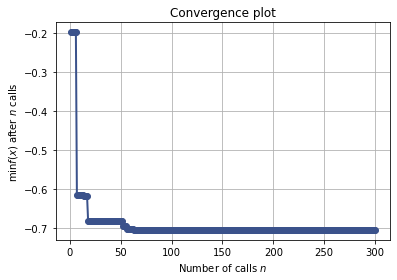

In [68]:
# realizando a otimização para 'combination_hsv+hu' (0.64)

bayesian_optimization(
   model=LGBMClassifier,
   field=FIELDS[0],
   space=space,
   keywords=keywords,
   additional_params=additional_params,
   n_calls=300
)

weight f1 = 0.712090554822666


{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'subsample': 0.8298111260102561,
 'colsample_bytree': 1.0}

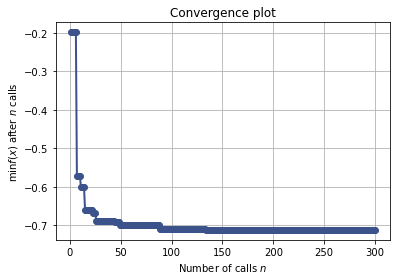

In [73]:
# realizando a otimização para 'descriptor_hsv' (0.64)

bayesian_optimization(
   model=LGBMClassifier,
   field=FIELDS[1],
   space=space,
   keywords=keywords,
   additional_params=additional_params,
   n_calls=300
)

In [79]:
X_train = [data[field]['train'] for field in FIELDS]
X_test = [data[field]['test'] for field in FIELDS]

In [84]:
lgbm_params1 = {
    'learning_rate': 0.1,
    'max_depth': 2,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8511519384156021,
    'n_estimators': 100,
    'subsample_freq': 1,
    'random_state': 42
}

lgbm_params2 = {
    'learning_rate': 0.1,
    'max_depth': 2,
    'min_child_weight': 1,
    'subsample': 0.8298111260102561,
    'colsample_bytree': 1.0,
    'n_estimators': 100,
    'subsample_freq': 1,
    'random_state': 42
}

# estimadores finais de cada stacking classifier
final_estimators = [
    LGBMClassifier(**lgbm_params1),
    LGBMClassifier(**lgbm_params2)
]

# estimadores de cada stacking classifier
estimators = [
    ('lsvc', LinearSVC(random_state=42)),
    ('mlp', MLPClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

setup = (estimators, final_estimators)

In [85]:
stacks = stack.load_stacking_models(fields=FIELDS, setup=setup)

simp = SimpsonsClassifier(stack_models=stacks)
simp.fit(X_train, y_train)
preds = simp.predict(X_test)

In [86]:
for field in FIELDS:
    print(field)
    print(classification_report(y_test, preds[field]))

combination_hsv+hu
              precision    recall  f1-score   support

           0       0.70      0.91      0.79        35
           1       0.78      0.84      0.81        25
           2       0.67      0.46      0.55        13
           3       1.00      0.40      0.57        10
           4       0.89      0.67      0.76        12

    accuracy                           0.75        95
   macro avg       0.81      0.66      0.70        95
weighted avg       0.77      0.75      0.73        95

descriptor_hsv
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        35
           1       0.80      0.80      0.80        25
           2       0.62      0.38      0.48        13
           3       0.67      0.40      0.50        10
           4       1.00      0.58      0.74        12

    accuracy                           0.75        95
   macro avg       0.76      0.63      0.67        95
weighted avg       0.76      0.75      0.73

In [87]:
# pesos aleatórios; scores obtidos (f1)
random_weights = []
weighted_f1 = []

# gerando 10000 matrizes aleatórias de pesos
for i in range(10000):
    weights = [[random.randint(1,3) for i in range(3)] for i in range(5)]

    # realizando a votação
    y_pred_election = vote.hard_voting(args=list(preds.values()),
                                       weights=weights)

    weighted_f1.append(
        f1_score(y_test, y_pred_election, average='weighted')
    )

    random_weights.append(weights)

# index do melhor score
idx = np.argmax(weighted_f1)
weights = random_weights[idx]

print('best weight f1 =', weighted_f1[idx])
print('weights')
print(weights)

best weight f1 = 0.7746862786543491
weights
[[1, 2, 3], [1, 3, 1], [2, 1, 2], [3, 3, 1], [2, 1, 3]]


In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');

plt.title(f"{field};\n accuracy = " \
        f"{round(accuracy_score(y_test, y_pred), 2)}; " \
        f"weight f1 = " \
        f"{round(f1_score(y_test, y_pred, average='weighted'), 2)}");

# **VOTING DE CLASSIFICADORES JÁ TREINADOS**

In [19]:
y_pred = vote.hard_voting(args=list(preds.values()),
                          weights=[1,1,1,1,1,1,1,1,1])

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 4, 4, 4, 4, 1, 4, 0, 4, 4, 4, 0, 0, 2, 0, 3,
       3, 3, 1, 0, 0, 3, 0], dtype=int64)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        35
           1       0.81      0.84      0.82        25
           2       0.50      0.08      0.13        13
           3       1.00      0.40      0.57        10
           4       0.89      0.67      0.76        12

    accuracy                           0.73        95
   macro avg       0.77      0.60      0.62        95
weighted avg       0.74      0.73      0.68        95



# **VOTING DE STACKS JÁ TREINADAS**

              precision    recall  f1-score   support

           0       0.73      0.94      0.83        35
           1       0.78      0.84      0.81        25
           2       0.86      0.46      0.60        13
           3       0.75      0.60      0.67        10
           4       1.00      0.67      0.80        12

    accuracy                           0.78        95
   macro avg       0.82      0.70      0.74        95
weighted avg       0.80      0.78      0.77        95



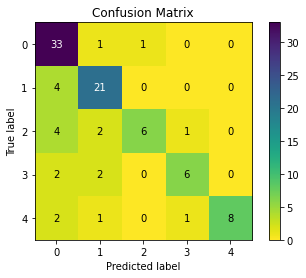

In [14]:
y_pred = vote.hard_voting(args=list(preds.values()),
                          weights=[3,1,2])

print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, cmap='viridis_r',
);

# **EXPLICABILIDADE (SHAP)**

              precision    recall  f1-score   support

           0       0.61      0.97      0.75        35
           1       0.72      0.84      0.78        25
           2       1.00      0.08      0.14        13
           3       1.00      0.40      0.57        10
           4       1.00      0.42      0.59        12

    accuracy                           0.68        95
   macro avg       0.87      0.54      0.57        95
weighted avg       0.78      0.68      0.63        95



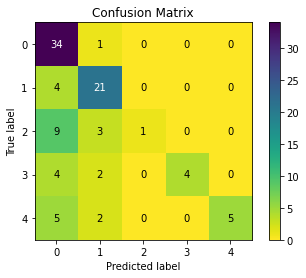

In [28]:
clf = LGBMClassifier()

X_train = np.array(data['combination_hsv+lbp+hu']['train'])
X_test = np.array(data['combination_hsv+lbp+hu']['test'])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, cmap='viridis_r',
);

In [31]:
explainer = shap.TreeExplainer(model=clf)
shap_values = explainer.shap_values(X_train)

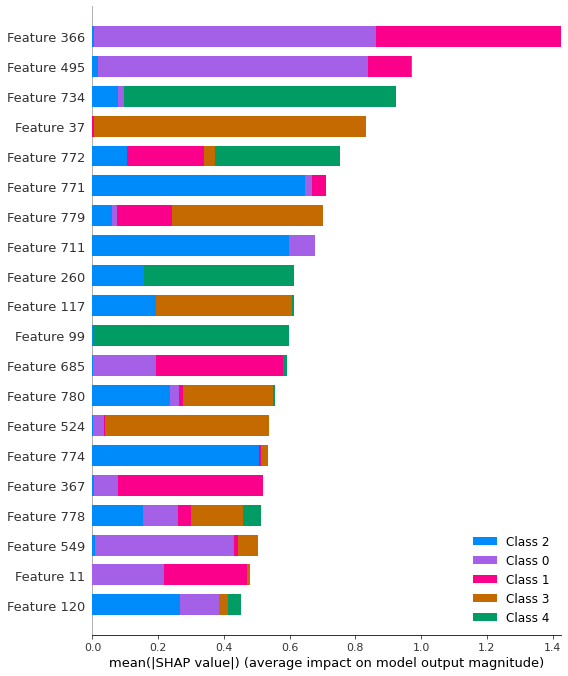

In [36]:
shap.summary_plot(shap_values=shap_values, features=X_train);